In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import joblib
import matplotlib.pyplot as plt

import re

from prophet import Prophet


# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path, parse_dates=True, index_col=0)

def scale_non_date_columns(df):
    #print(df.info())
    # Filter out date columns and non-numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    if numeric_cols.empty:
        return df, None

    df_scaled = pd.DataFrame(index=df.index)

    scaler = StandardScaler()

    # Iterate through each column
    for column in df.columns:
        if df[column].dtype in ['float64', 'int64']:
            # Scale column
            scaled_column = scaler.fit_transform(df[[column]])
            df_scaled[column] = scaled_column.flatten()  # Add scaled column to df_scaled
        else:
            # Keep column
            df_scaled[column] = df[column]

    return df_scaled, scaler

# Transformer to rename datetime column
class RenameDatetimeColumn(BaseEstimator, TransformerMixin):
    def detect_datetime_column(self, column_name):
        patterns = [
            r'\bdate\b',          # contains 'date'
            r'\bdatetime\b',      # contains 'datetime'
            r'\btimestamp\b',     # contains 'timestamp'
            r'\byear\b',          # contains 'year'
            r'\bmonth\b',         # contains 'month'
            r'\bday\b'            # contains 'day'
        ]
        return any(re.search(pattern, column_name.lower()) for pattern in patterns)

    def convert_to_datetime(self, series, expected_format):
        # Try expected format first
        series_converted = pd.to_datetime(series, errors='coerce', format=expected_format)
        if series_converted.isna().all():
            # If expected format fails, try without format
            series_converted = pd.to_datetime(series, errors='coerce')
            if series_converted.isna().all():
                # If both fail, try 'dd/mm/yyyy' format
                series_converted = pd.to_datetime(series, errors='coerce', format='%d/%m/%Y')
        return series_converted

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Check if the index contains datetime information
        if X.index.name and self.detect_datetime_column(X.index.name):
            try:
                X.index = self.convert_to_datetime(X.index, expected_format='%Y-%m-%d')
                X.index.names = ['Date']
                X=X.reset_index()
                #print("X info : ")
                #print(X.info())
                print(f"Renamed index to 'Date' and converted to datetime format.")
            except ValueError:
                print(f"Failed to convert index to datetime.")
        else:
            # Check each column for datetime patterns and attempt conversion
            for col in X.columns:
                if self.detect_datetime_column(col):
                    try:
                        X[col] = self.convert_to_datetime(X[col], expected_format='%Y-%m-%d')
                        X.rename(columns={col: 'Date'}, inplace=True)
                        print(f"Renamed '{col}' column to 'Date' and converted to datetime format.")
                        return X  # Return immediately after renaming first datetime column
                    except ValueError:
                        print(f"Failed to convert column '{col}' to datetime.")

            # Convert object columns to datetime
            for col in X.select_dtypes(include=['object']):
                try:
                    X[col] = self.convert_to_datetime(X[col], expected_format='%Y-%m-%d')
                except ValueError:
                    pass

            # Identify datetime columns after conversion
            date_columns = X.select_dtypes(include=['datetime64']).columns
            if not date_columns.empty:
                original_name = date_columns[0]
                X.rename(columns={original_name: 'Date'}, inplace=True)
                print(f"Renamed '{original_name}' column to 'Date' and converted to datetime format.")
            else:
                print("No datetime columns found.")

        return X


# Transformer to impute missing values
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in X.select_dtypes(include=['object']):
            try:
                X[col] = pd.to_datetime(X[col], errors='coerce')
            except ValueError:
                pass

        X.fillna(X.mean(), inplace=True)
        return X


# Preprocessing pipeline
def preprocess_data_pipeline(file_path, Y_variable, scale):
    # Load data
    df = load_data(file_path)

    # Instantiate transformers
    rename_datetime = RenameDatetimeColumn()
    impute_missing = ImputeMissingValues()

    # Pipeline definition
    pipeline = Pipeline([
        ('rename_datetime', rename_datetime),
        ('impute_missing', impute_missing)
    ])

    # Fit-transform the pipeline
    df_preprocessed = pipeline.fit_transform(df)
    print("//////////////////////////")
    print(df_preprocessed.info())
    # Ensure target variable exists
    if Y_variable not in df_preprocessed.columns:
        raise ValueError(f"Target variable '{Y_variable}' not found in the dataset.")

    # Separate X and Y
    X = df_preprocessed.drop(columns=[Y_variable])
    y = df_preprocessed[Y_variable]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if(scale):
      # Scale X data
      X_train_scaled, scaler_X = scale_non_date_columns(X_train)
      if scaler_X is None:
          print("Not scaling")
          X_test_scaled = X_test
          X_train_scaled = X_train
      else:
          X_test_scaled, scaler_X = scale_non_date_columns(X_test)
          X_train_scaled, scaler_X = scale_non_date_columns(X_train)

      # Scale y data
      scaler_y = StandardScaler()
      y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
      y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
      joblib.dump(scaler_y, 'scaler_y.joblib')

    else:
      X_test_scaled = X_test
      X_train_scaled = X_train
      y_train_scaled = y_train
      y_test_scaled = y_test

    feature_names = list(X.columns)

    print("Features : ", feature_names)
    if 'Date' in feature_names:
        feature_names.remove('Date')

    if X_train_scaled.index.name == 'Date':
        train_df_scaled = X_train_scaled.copy()
        train_df_scaled[Y_variable] = y_train_scaled
        test_df_scaled = X_test_scaled.copy()
        test_df_scaled[Y_variable] = y_test_scaled
        print("date")
    else:
        train_df_scaled = X_train_scaled.copy()
        train_df_scaled['Date'] = X_train_scaled['Date']
        train_df_scaled[Y_variable] = y_train_scaled
        test_df_scaled = X_test_scaled.copy()
        test_df_scaled['Date'] = X_test_scaled['Date']
        test_df_scaled[Y_variable] = y_test_scaled
        print("date2")

    # Rename 'Date' and Y_variable columns for Prophet
    train_df_scaled = train_df_scaled.rename(columns={'Date': 'ds', Y_variable: 'y'})
    test_df_scaled = test_df_scaled.rename(columns={'Date': 'ds', Y_variable: 'y'})

    X_test_scaled_renamed=X_test_scaled.rename(columns={'Date': 'ds'})
    # Initialize Prophet model
    model = Prophet()

    # Add regressors (features)
    for feature in feature_names:
        print(feature, "added")
        model.add_regressor(feature)

    print("c bon")
    model.fit(train_df_scaled)
    print("c bon")
    joblib.dump(model, 'prophet_model.pkl')

    print(X_test_scaled_renamed.info())

    # Predicting
    future = model.make_future_dataframe(periods=len(X_test_scaled_renamed))
    future = future.merge(X_test_scaled_renamed.reset_index(drop=True), on='ds', how='left')

    #forecast = model.predict(future)
    forecast = model.predict(X_test_scaled_renamed)
    y_pred = forecast['yhat'].iloc[-len(X_test):].values

    # Imputing nan values in y_pred
    if np.isnan(y_pred).any():
        y_pred = pd.Series(y_pred).fillna(y_pred.mean()).values
    mape = mean_absolute_percentage_error(y_test_scaled, y_pred)

    model.plot(forecast)
    plt.title('Forecasting')
    plt.xlabel('Date')
    plt.ylabel(Y_variable)
    plt.show()

    print("Mape : ", mape, "%")

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, mape, model, forecast, feature_names, df_preprocessed


Renamed index to 'Date' and converted to datetime format.
//////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                248 non-null    datetime64[ns]
 1   Symbol              0 non-null      datetime64[ns]
 2   Series              0 non-null      datetime64[ns]
 3   Prev Close          248 non-null    float64       
 4   Open                248 non-null    float64       
 5   High                248 non-null    float64       
 6   Low                 248 non-null    float64       
 7   Last                248 non-null    float64       
 8   Close               248 non-null    float64       
 9   VWAP                248 non-null    float64       
 10  Volume              248 non-null    int64         
 11  Turnover            248 non-null    float64       
 12  Trades              2

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Symbol added
Series added
Prev Close added
Open added
High added
Low added
Last added
VWAP added
Volume added
Turnover added
Trades added
Deliverable Volume added
%Deliverble added
c bon


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/4m8icn82.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/dn7om3x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69023', 'data', 'file=/tmp/tmpg1q_7zsg/4m8icn82.json', 'init=/tmp/tmpg1q_7zsg/dn7om3x5.json', 'output', 'file=/tmp/tmpg1q_7zsg/prophet_modelib3dphoo/prophet_model-20240719140905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
14:09:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/mwkgcip7.json
DE

c bon
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 33 to 172
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ds                  50 non-null     datetime64[ns]
 1   Symbol              0 non-null      datetime64[ns]
 2   Series              0 non-null      datetime64[ns]
 3   Prev Close          50 non-null     float64       
 4   Open                50 non-null     float64       
 5   High                50 non-null     float64       
 6   Low                 50 non-null     float64       
 7   Last                50 non-null     float64       
 8   VWAP                50 non-null     float64       
 9   Volume              50 non-null     float64       
 10  Turnover            50 non-null     float64       
 11  Trades              50 non-null     float64       
 12  Deliverable Volume  50 non-null     float64       
 13  %Deliverble         50 non-null     float64      

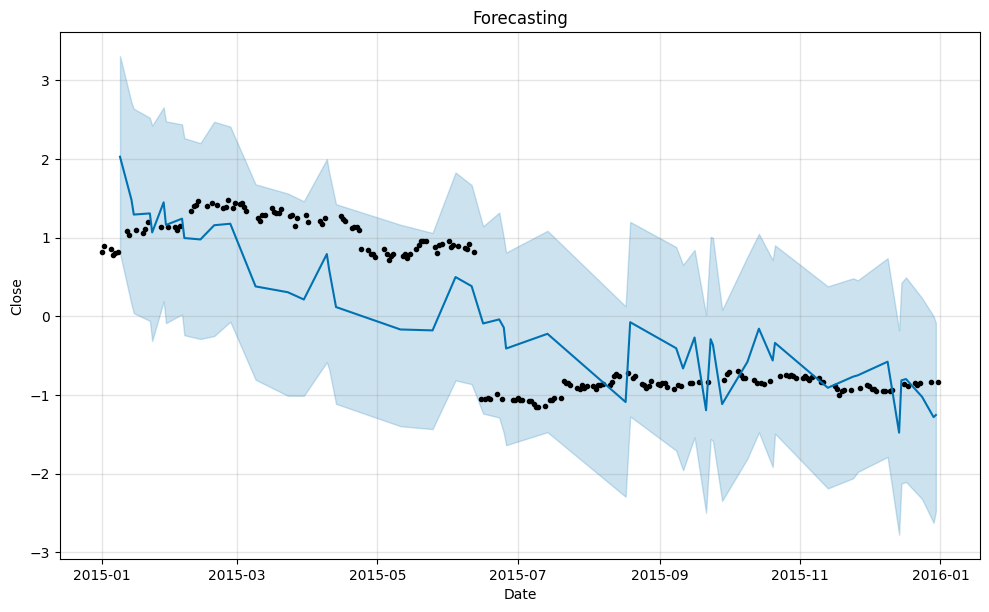

Mape :  1.1719990171085102 %


In [ ]:
# Usage example
file_path = 'infy_stock.csv'
Y_variable = 'Close'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, mape, model, forecast, feature_names, df_preprocessed = preprocess_data_pipeline(file_path, Y_variable,True)

if X_train_scaled.index.name == 'Date':
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

#print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
#print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
#print("\nScaled Training dataset preview:")
#print(train_df_scaled.head())

<ipython-input-2-1d4a077a9cac>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(file_path, parse_dates=True, index_col=0)
<ipython-input-2-1d4a077a9cac>:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series_converted = pd.to_datetime(series, errors='coerce')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/bgyqbkj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/0sdej305.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/

Renamed 'TxnDate' column to 'Date' and converted to datetime format.
//////////////////////////
<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 76229 to 98038
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1228 non-null   datetime64[ns]
 1   TxnTime      1228 non-null   datetime64[ns]
 2   Consumption  1228 non-null   float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 38.4 KB
None
Features :  ['Date', 'TxnTime']
date2
TxnTime added
c bon


14:10:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


c bon
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 83931 to 89980
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       246 non-null    datetime64[ns]
 1   TxnTime  246 non-null    datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 5.8 KB
None


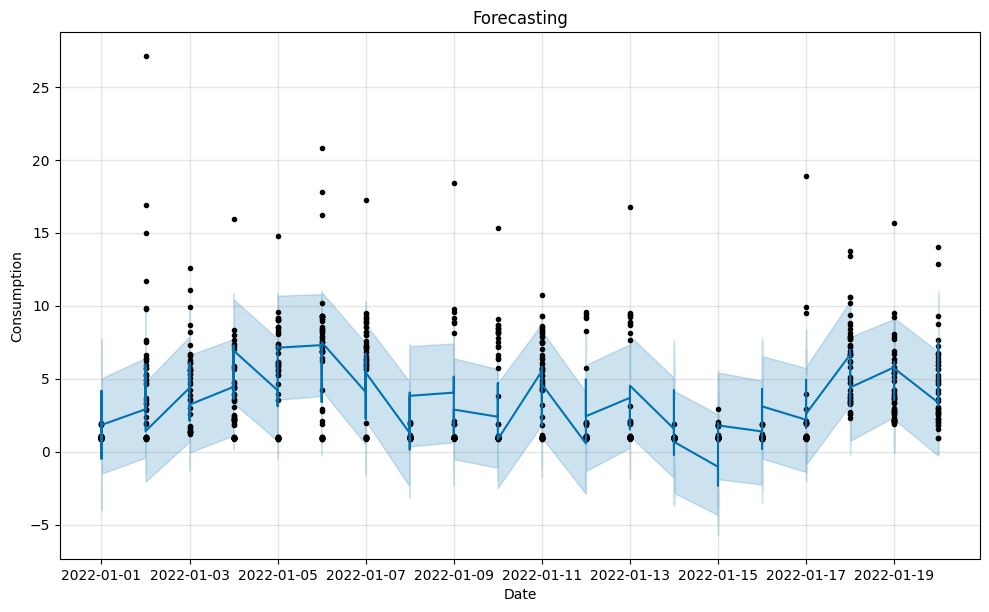

Mape :  1.9158098523353135 %
Train dataset shape after scaling: (982, 2)
Test dataset shape after scaling: (246, 2)

Scaled Training dataset preview:
            Date  Consumption
92952 2022-01-19        4.832
93027 2022-01-18        2.276
86307 2022-01-06        1.872
86933 2022-01-07        7.964
80273 2022-01-11        4.638


In [ ]:
# Usage example
file_path = 'energy.csv'
Y_variable = 'Consumption'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, mape, model, forecast, feature_names, df_preprocessed = preprocess_data_pipeline(file_path, Y_variable,False)

if X_train_scaled.index.name == 'Date':
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
print("\nScaled Training dataset preview:")
print(train_df_scaled.head())

Renamed index to 'Date' and converted to datetime format.
//////////////////////////
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1009 non-null   datetime64[ns]
 1   Open       1009 non-null   float64       
 2   High       1009 non-null   float64       
 3   Low        1009 non-null   float64       
 4   Close      1009 non-null   float64       
 5   Adj Close  1009 non-null   float64       
 6   Volume     1009 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.3 KB
None
Features :  ['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume']
date2
Open added
High added
Low added
Adj Close added
Volume added
c bon


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/4ewch0tl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/rg1hmtod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95332', 'data', 'file=/tmp/tmpg1q_7zsg/4ewch0tl.json', 'init=/tmp/tmpg1q_7zsg/rg1hmtod.json', 'output', 'file=/tmp/tmpg1q_7zsg/prophet_modelpt0u2oqk/prophet_model-20240719141004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


c bon
<class 'pandas.core.frame.DataFrame'>
Index: 202 entries, 628 to 78
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         202 non-null    datetime64[ns]
 1   Open       202 non-null    float64       
 2   High       202 non-null    float64       
 3   Low        202 non-null    float64       
 4   Adj Close  202 non-null    float64       
 5   Volume     202 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 11.0 KB
None


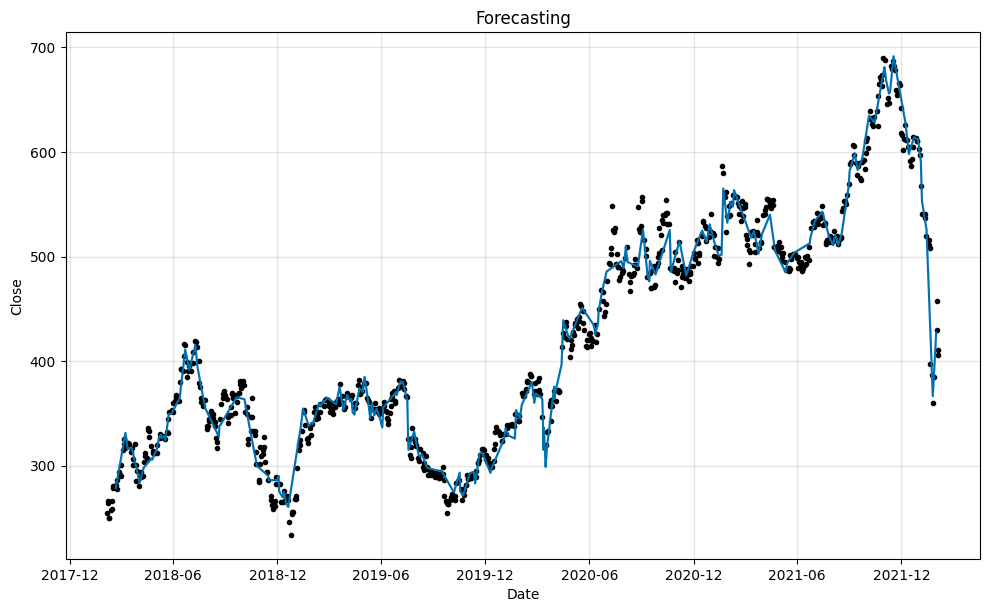

Mape :  0.31345764336790155 %
Train dataset shape after scaling: (807, 2)
Test dataset shape after scaling: (202, 2)

Scaled Training dataset preview:
          Date       Close
29  2018-03-19  313.480011
280 2019-03-19  358.779999
507 2020-02-11  373.690002
706 2020-11-23  476.619995
877 2021-07-30  517.570007


In [ ]:
# Usage example
file_path = 'NFLX.csv'
Y_variable = 'Close'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, mape, model, forecast, feature_names , df_preprocessed= preprocess_data_pipeline(file_path, Y_variable,False)

if X_train_scaled.index.name == 'Date':
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
print("\nScaled Training dataset preview:")
print(train_df_scaled.head())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Renamed 'date' column to 'Date' and converted to datetime format.
//////////////////////////
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 2019-12-06 to 2019-12-06
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   value         816 non-null    float64       
 1   Date          816 non-null    datetime64[ns]
 2   realtime_end  816 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1)
memory usage: 25.5 KB
None
Features :  ['Date', 'realtime_end']
date2
realtime_end added
c bon


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/_8fha1y5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/69tq9nkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45758', 'data', 'file=/tmp/tmpg1q_7zsg/_8fha1y5.json', 'init=/tmp/tmpg1q_7zsg/69tq9nkn.json', 'output', 'file=/tmp/tmpg1q_7zsg/prophet_model4eiisjpu/prophet_model-20240719141012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
14:10:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg1q_7zsg/79y1es_l.json
DE

c bon
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164 entries, 2019-12-06 to 2019-12-06
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            164 non-null    datetime64[ns]
 1   realtime_end  164 non-null    datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 3.8 KB
None


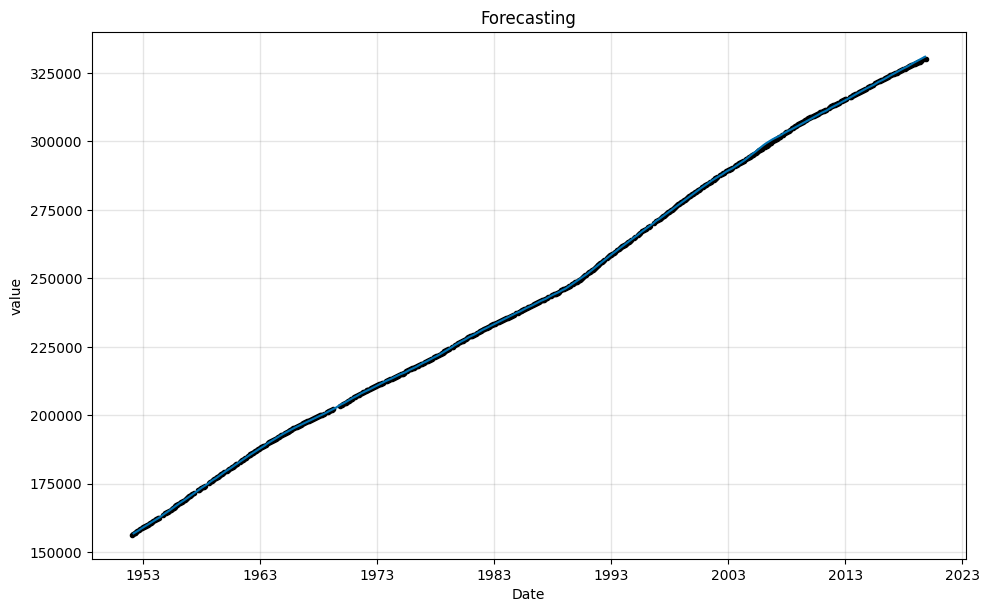

Mape :  0.2238651330665286 %
Train dataset shape after scaling: (652, 2)
Test dataset shape after scaling: (164, 2)

Scaled Training dataset preview:
                     Date     value
realtime_start                     
2019-12-06     1989-05-01  246906.0
2019-12-06     1979-12-01  226243.0
2019-12-06     1976-07-01  218035.0
2019-12-06     2009-01-01  306208.0
2019-12-06     1958-08-01  175143.0


In [ ]:

# Usage example
file_path = 'POP.csv'
Y_variable = 'value'

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, mape, model, forecast, feature_names, df_preprocessed = preprocess_data_pipeline(file_path, Y_variable,False)

if X_train_scaled.index.name == 'Date':
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled.index, Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled.index, Y_variable: y_test_scaled})
else:
    train_df_scaled = pd.DataFrame({'Date': X_train_scaled['Date'], Y_variable: y_train_scaled})
    test_df_scaled = pd.DataFrame({'Date': X_test_scaled['Date'], Y_variable: y_test_scaled})

print(f"Train dataset shape after scaling: {train_df_scaled.shape}")
print(f"Test dataset shape after scaling: {test_df_scaled.shape}")
print("\nScaled Training dataset preview:")
print(train_df_scaled.head())